#  library

main() 함수 내 crawler() 함수 수행

In [1]:
 # -*- coding: utf-8 -*-
from bs4 import BeautifulSoup
from datetime import datetime
import requests
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
"""
fname = '한국행정구역분류_2022.1.1.기준.xlsx'
data_region = pd.read_excel(fname, sheet_name = [1], skiprows=2, dtype={'대분류':str, '중분류':str, '소분류':str})
data_region[1].drop('Unnamed: 0', axis=1, inplace=True)
data_citydo_all = data_region[1]['시도'][1:]
data_citydo_unique = data_citydo_all.unique()
booleanArray1 = [not pd.isnull(number) for number in data_citydo_unique]
data_citydo_unique_notna = data_citydo_unique[booleanArray1]
data_citydo_unique_notna
data_citygungu_all = data_region[1]['시군구'][1:]
data_citygungu_unique = data_citygungu_all.unique()
data_citygungu_unique
"""

"\nfname = '한국행정구역분류_2022.1.1.기준.xlsx'\ndata_region = pd.read_excel(fname, sheet_name = [1], skiprows=2, dtype={'대분류':str, '중분류':str, '소분류':str})\ndata_region[1].drop('Unnamed: 0', axis=1, inplace=True)\ndata_citydo_all = data_region[1]['시도'][1:]\ndata_citydo_unique = data_citydo_all.unique()\nbooleanArray1 = [not pd.isnull(number) for number in data_citydo_unique]\ndata_citydo_unique_notna = data_citydo_unique[booleanArray1]\ndata_citydo_unique_notna\ndata_citygungu_all = data_region[1]['시군구'][1:]\ndata_citygungu_unique = data_citygungu_all.unique()\ndata_citygungu_unique\n"

# 크롤링

- 크롤링 해오는 것 : 링크,제목,신문사,내용요약본
- 키워드 : 붉은물, 적수, 유충


- 내용요약본  -> 정제 작업 필요
- 리스트 -> 딕셔너리 -> df -> 엑셀로 저장

In [3]:
cos = []

In [107]:
flag_save = 0

maxpage = input("최대 크롤링할 페이지 수 입력하시오: ")  # 1
sort = input("뉴스 검색 방식 입력(관련도순=0  최신순=1  오래된순=2): ") # 0

s_date = '2019.08.08' # 2019.05.10  2019.05.20  2019.05.30  2019.06.09  2019.06.19  2019.06.29  2019.07.09  2019.07.19  2019.07.29  2019.08.08
e_date = '2019.08.17' # 2019.05.19  2019.05.29  2019.06.08  2019.06.18  2019.06.28  2019.07.08  2019.07.18  2019.07.28  2019.08.07  2019.08.17

#각 크롤링 결과 저장하기 위한 리스트 선언
title_text=[]
link_text=[]
source_text=[]
contents_text=[]
result={}

#엑셀로 저장하기 위한 변수
#RESULT_PATH ='C:/'  #결과 저장할 경로
now = datetime.now() #파일이름 현 시간으로 저장하기

#내용 정제화 함수
def contents_cleansing(contents):
    first_cleansing_contents = re.sub('<dl>.*?</a> </div> </dd> <dd>', '',str(contents)).strip()  #앞에 필요없는 부분 제거
    second_cleansing_contents = re.sub('<ul class="relation_lst">.*?</dd>', '', first_cleansing_contents).strip()#뒤에 필요없는 부분 제거 (새끼 기사)
    third_cleansing_contents = re.sub('<.+?>', '', second_cleansing_contents).strip()
    contents_text.append(third_cleansing_contents)
    #print(contents_text)

#크롤링 시작
list_region = ['인천']

for region in list_region:
    list_keyword = ['수돗물적수']
    for keyword in list_keyword:
        query = region +' ' + keyword
        s_from = s_date.replace(".","")
        e_to = e_date.replace(".","")
        page = 1
        maxpage_t =(int(maxpage)-1)*10+1   # 11= 2페이지 21=3페이지 31=4페이지  ...81=9페이지 , 91=10페이지, 101=11페이지
        while page <= maxpage_t:
            url = "https://search.naver.com/search.naver?where=news&query=" + query + "&sort="+sort+"&ds=" + s_date + "&de=" + e_date + "&nso=so%3Ar%2Cp%3Afrom" + s_from + "to" + e_to + "%2Ca%3A&start=" + str(page)
            response = requests.get(url)
            html = response.text

            #뷰티풀소프의 인자값 지정
            soup = BeautifulSoup(html, 'html.parser')

            #<a>태그에서 제목과 링크주소 (a 태그 중 class 명이 news_tit인 것)
            atags = soup.find_all('a', 'news_tit')
            for atag in atags:
                title = atag.get('title')
                title_text.append(title)     #제목
                link_text.append(atag['href'])   #링크주소

            #신문사 추출 (a 태그 중 class 명이 info press인 것)
            source_lists = soup.find_all('a', 'info press')
            for source_list in source_lists:
                source_text.append(source_list.text)    #신문사

            #본문요약본 (a 태그 중 class 명이 api_txt_lines dsc_txt_wrap인 것)
            contents_lists = soup.find_all('a','api_txt_lines dsc_txt_wrap')
            for contents_list in contents_lists:
                contents_cleansing(contents_list) #본문요약 정제화

            #모든 리스트 딕셔너리형태로 저장
            result= {"title":title_text ,  "source" : source_text ,"contents": contents_text ,"link":link_text }
            df = pd.DataFrame(result)  #df로 변환
            page += 10
            print(df)

if flag_save == 1:
    # 새로 만들 파일이름 지정
    outputFileName = '%s-%s-%s %s시 %s분 %s초 merging' % (now.year, now.month, now.day, now.hour, now.minute, now.second)
    df.to_excel(outputFileName+'.xlsx',sheet_name='sheet1')
    #df.to_csv(outputFileName+'.csv', mode='w')

최대 크롤링할 페이지 수 입력하시오: 1
뉴스 검색 방식 입력(관련도순=0  최신순=1  오래된순=2): 0
                                             title      source  \
0                   붉은 수돗물 피해 주민들 "정상화 아냐"…집단소송 예고  연합뉴스언론사 선정   
1                              수돗물 적수 이어 이번엔 역한 냄새      파이낸셜뉴스   
2                    포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시       NSP통신   
3                 인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수         뉴스1   
4                     '적수 사태 진상규명' 인천시의회 특위 행정사무조사        경인일보   
5                인천 '붉은 수돗물' 피해보상…사흘간 2333명 4억원 접수        경향신문   
6                     인천시의회 특위, 붉은 수돗물 조사 호통치기에 그쳐        중부일보   
7        인천시의회, '붉은 수돗물' 특위...탁도계 업체 "탁도계 고장 사실아냐"        경인방송   
8              인천 붉은 수돗물 피해주민들 “피해보상 청구서가 서약서냐” 발끈        한국경제   
9  시의회 수돗물 적수사고 특위, 탁도계 업체 사장 "공촌정수장 탁도계 고장 사실 아냐"        경기일보   

                                            contents  \
0  주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...   
1  적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...   
2  막여과 시험이란 수돗물 1리터를 공극 0.45㎛ 여과지에 걸러서 여과된 상

In [108]:
list_search = ' '.join(list_region) + ' ' + ' '.join(list_keyword)
dfNew = pd.Series(list_search)
df_tfidf_base = df['contents'].append(dfNew,ignore_index=True)

corpus = df_tfidf_base
corpus

C:\Users\qpflw\AppData\Local\Temp/ipykernel_46540/123471369.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tfidf_base = df['contents'].append(dfNew,ignore_index=True)


0     주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...
1     적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...
2     막여과 시험이란 수돗물 1리터를 공극 0.45㎛ 여과지에 걸러서 여과된 상태(변색 ...
3     인천시가 ‘붉은 수돗물’(적수) 피해보상 절차에 착수한다. 시는 오는 12~30일 ...
4     13일 오전 인천시의회에서 열린 '수돗물 적수 사고 행정사무조사'에서 전·현직 상수...
5     인천 ‘붉은 수돗물’ 사태로 인한 피해보상 접수가 사흘만에 4000여 건이 넘은 것...
6     윤상순기자 인천 수돗물 적수 사태와 관련해 인천시의회 특별위원회 소속 의원들이 전 ...
7     (앵커)환경부가 인천 '붉은 수돗물' 사태의 원인으로 꼽은 '탁도계 고장'이 사실이...
8     시는 지난 5일 적수사태 정상화를 선언하면서 서구·영종도·강화 등 피해지역의 상하수...
9     인천 붉은 수돗물(적수) 사태의 주 원인으로 꼽히는 공촌정수장 탁도계 고장이 사실이...
10                                             인천 수돗물적수
dtype: object

In [109]:
df

,title,source,contents,link
0,"붉은 수돗물 피해 주민들 ""정상화 아냐""…집단소송 예고",연합뉴스언론사 선정,"주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...",http://yna.kr/AKR20190811025500065?did=1195m
1,수돗물 적수 이어 이번엔 역한 냄새,파이낸셜뉴스,적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...,http://www.fnnews.com/news/201908131312234449
2,"포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시",NSP통신,막여과 시험이란 수돗물 1리터를 공극 0.45㎛ 여과지에 걸러서 여과된 상태(변색 ...,http://www.nspna.com/news/?mode=view&newsid=37...
3,인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수,뉴스1,인천시가 ‘붉은 수돗물’(적수) 피해보상 절차에 착수한다. 시는 오는 12~30일 ...,http://news1.kr/articles/?3691442
4,'적수 사태 진상규명' 인천시의회 특위 행정사무조사,경인일보,13일 오전 인천시의회에서 열린 '수돗물 적수 사고 행정사무조사'에서 전·현직 상수...,http://www.kyeongin.com/main/view.php?key=2019...
5,인천 '붉은 수돗물' 피해보상…사흘간 2333명 4억원 접수,경향신문,인천 ‘붉은 수돗물’ 사태로 인한 피해보상 접수가 사흘만에 4000여 건이 넘은 것...,http://news.khan.co.kr/kh_news/khan_art_view.h...
6,"인천시의회 특위, 붉은 수돗물 조사 호통치기에 그쳐",중부일보,윤상순기자 인천 수돗물 적수 사태와 관련해 인천시의회 특별위원회 소속 의원들이 전 ...,http://www.joongboo.com/news/articleView.html?...
7,"인천시의회, '붉은 수돗물' 특위...탁도계 업체 ""탁도계 고장 사실아냐""",경인방송,(앵커)환경부가 인천 '붉은 수돗물' 사태의 원인으로 꼽은 '탁도계 고장'이 사실이...,http://www.ifm.kr/news/262814
8,인천 붉은 수돗물 피해주민들 “피해보상 청구서가 서약서냐” 발끈,한국경제,시는 지난 5일 적수사태 정상화를 선언하면서 서구·영종도·강화 등 피해지역의 상하수...,https://www.hankyung.com/society/article/20190...
9,"시의회 수돗물 적수사고 특위, 탁도계 업체 사장 ""공촌정수장 탁도계 고장 사실 아냐""",경기일보,인천 붉은 수돗물(적수) 사태의 주 원인으로 꼽히는 공촌정수장 탁도계 고장이 사실이...,http://www.kyeonggi.com/news/articleView.html?...


# 벡터화

In [110]:
tfidfv = TfidfVectorizer().fit(corpus)
tfidfv_array = tfidfv.transform(corpus).toarray()

In [111]:
tfidfv_array

array([[0.15982462, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.17350095],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# 유사도

In [112]:
cos_sim_df = pd.DataFrame(cosine_similarity(tfidfv_array, tfidfv_array)) 
cos_sim_df

,0,1,2,3,4,5,6,7,8,9,10
0,1.000000,0.036828,0.034216,0.131293,0.080651,0.053419,0.052358,0.040327,0.046411,0.061713,0.072361
1,0.036828,1.000000,0.019964,0.019018,0.034172,0.082981,0.021662,0.026739,0.021857,0.046242,0.000000
2,0.034216,0.019964,1.000000,0.011216,0.039843,0.032580,0.027477,0.010613,0.005359,0.022531,0.000000
3,0.131293,0.019018,0.011216,1.000000,0.024046,0.070716,0.012169,0.017254,0.090789,0.028401,0.000000
4,0.080651,0.034172,0.039843,0.024046,1.000000,0.024395,0.043231,0.134819,0.018639,0.181130,0.000000
5,0.053419,0.082981,0.032580,0.070716,0.024395,1.000000,0.020326,0.024751,0.062011,0.035851,0.037911
6,0.052358,0.021662,0.027477,0.012169,0.043231,0.020326,1.000000,0.043107,0.037717,0.032349,0.042562
7,0.040327,0.026739,0.010613,0.017254,0.134819,0.024751,0.043107,1.000000,0.025484,0.315059,0.038653
8,0.046411,0.021857,0.005359,0.090789,0.018639,0.062011,0.037717,0.025484,1.000000,0.045636,0.039033
9,0.061713,0.046242,0.022531,0.028401,0.181130,0.035851,0.032349,0.315059,0.045636,1.000000,0.037535


In [113]:
len_contents = len(cos_sim_df)-1
len_contents

10

In [114]:
cos_sim_df_sorted = cos_sim_df.iloc[len_contents].sort_values(ascending=False)
cos_sim_df_sorted

10    1.000000
0     0.072361
6     0.042562
8     0.039033
7     0.038653
5     0.037911
9     0.037535
1     0.000000
2     0.000000
3     0.000000
4     0.000000
Name: 10, dtype: float64

In [115]:
cos_sim_df_sorted_others = cos_sim_df_sorted[1:]
cos_sim_df_sorted_others

cos_sim_df_sorted_others_sum = cos_sim_df_sorted_others.sum()/10 * 100 # percent 지표
print(cos_sim_df_sorted_others_sum)

2.680558129862826


In [116]:
cos.append(cos_sim_df_sorted_others_sum)
cos

[0.0,
 0.0,
 2.0260405225322438,
 2.2496631242461738,
 3.167007436910682,
 2.073423730490449,
 4.182259417804383,
 2.161944442903001,
 0.9414450545768863,
 2.680558129862826]

In [117]:
cos_df = pd.DataFrame(cos)
cos_df

,0
0,0.000000
1,0.000000
2,2.026041
3,2.249663
4,3.167007
5,2.073424
6,4.182259
7,2.161944
8,0.941445
9,2.680558


# 시각화

In [118]:
plt.rc("font", family="Malgun Gothic") # window

Text(0.5, 1.0, '네이버 코사인 유사도(%)')

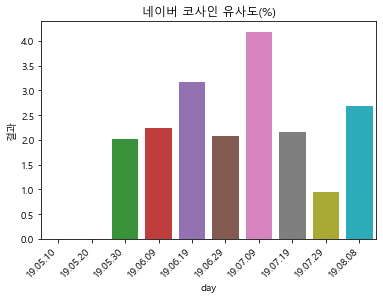

In [119]:
df1=pd.DataFrame({'day':('19.05.10','19.05.20','19.05.30','19.06.09','19.06.19','19.06.29', '19.07.09', '19.07.19', '19.07.29', '19.08.08'),'결과':cos})
p = sns.barplot(data = df1, x ='day',y='결과')
p.set_xticklabels(p.get_xticklabels(), rotation=45, horizontalalignment='right')
p.set_title("네이버 코사인 유사도(%)")